# Data analysis after training

Plot the test cases with examples of the best and worst mean relative error

In [1]:
%reload_ext autoreload 
%autoreload 2

import pickle 
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import r2_score

import data_parser
import Model

In [2]:
# CUDA
if torch.cuda.is_available():
    dev = "cuda:0"
    print("CUDA avaiable")
else:  
    dev = "cpu"
    print("CUDA not avaiable")
device = torch.device(dev)

CUDA avaiable


In [3]:
df = data_parser.calculate_amp_phase(data_parser.data_parse(), unwrap=True)

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.0):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.Dropout(p=dropout_rate),
            nn.ReLU(),
            nn.Linear(500, out_features)
        )

    def forward(self, x):

        return self.layers(x)


In [4]:
def plot_X_y(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
             figname=None, savefig=False):
    clear_output(wait=True)
    # Plot a 3x3 figure
    line = 5
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)
    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy())
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy())
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
        
    plt.show();

def plot_X_y_with_example(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
                          idx_h=None, max_mre=None, idx_l=None, min_mre=None, figname=None, savefig=False):
    clear_output(wait=True)
    # Plot a 3x3 figure
    line = 5
    
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)
    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy(), label='truth')
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy(), label='prediction')
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)
            ax[i,j].legend(loc='upper right')
    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
    
    plt.show();
    
    if idx_h is not None:
        fig_1, ax_1 = plt.subplots(figsize=(20, 3), constrained_layout=True)
        idx = indices[idx_h]
        input_col_str = ''
        for input_col in input_cols:
            input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
        ax_1.plot(X.detach().numpy(), y[idx_h,:].detach().numpy(), label='truth')
        if pred is not None:
            ax_1.plot(X.detach().numpy(), pred[idx_h,:].detach().numpy(), label='prediction')
        ax_1.set_xlabel(input_col_str)
        ax_1.set_ylabel(y_label)
        ax_1.legend(loc='upper right')
        title = 'Highest Max Relative Error: %.4f' % (max_mre)
        fig_1.suptitle(title)
        
        if savefig:
            plt.savefig('../Figures/pdf/'+figname+'_max_error.pdf', bbox_inches= 'tight')
            plt.savefig('../Figures/png/'+figname+'_max_error.png', bbox_inches= 'tight')
    
    plt.show();
    if idx_l is not None:
        fig_2, ax_2 = plt.subplots(figsize=(20, 3), constrained_layout=True)
        idx = indices[idx_l]
        input_col_str = ''
        for input_col in input_cols:
            input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
        ax_2.plot(X.detach().numpy(), y[idx_l,:].detach().numpy(), label='truth')
        if pred is not None:
            ax_2.plot(X.detach().numpy(), pred[idx_l,:].detach().numpy(), label='prediction')
        ax_2.set_xlabel(input_col_str)
        ax_2.set_ylabel(y_label)
        ax_2.legend(loc='upper right')
        title = 'Lowest Max Relative Error: %.4f' % (min_mre)
        fig_2.suptitle(title)
        
        if savefig:
            plt.savefig('../Figures/pdf/'+figname+'_min_error.pdf', bbox_inches= 'tight')
            plt.savefig('../Figures/png/'+figname+'_min_error.png', bbox_inches= 'tight')
        
    plt.show();
        
def plot_X_y_train(X, y, df, indices, input_cols, y_label, pred=None, loss=None, r2=None, mer=None, \
                   figname=None, savefig=False):
    clear_output(wait=True)
    # Plot a 3x3 figure
    line = 20
    
    fig, ax = plt.subplots(line, 3, figsize=(40, 3 * line), constrained_layout=True)
    
    for i in range(line):
        for j in range(3):
        
            idx = indices[i*3+j]
            input_col_str = ''
            for input_col in input_cols:
                input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
            
            ax[i,j].plot(X.detach().numpy(), y[i*3+j,:].detach().numpy())
            if pred is not None:
                ax[i,j].plot(X.detach().numpy(), pred[i*3+j,:].detach().numpy())
            ax[i,j].set_xlabel(input_col_str)
            ax[i,j].set_ylabel(y_label)

    title = 'Loss: %.4f R2 : %.4f Max Error Rate : %.4f' % (loss, r2, mer)
    fig.suptitle(title)
    
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
    plt.show();
    
def plot_X_y_analysis(X, pred, indices, in_train, input_cols, y_label, y=None, title=None, \
                     figname=None, savefig=False):
    
    clear_output(wait=True)
    line = pred.shape[0]
    
    fig, ax = plt.subplots(line, 1, figsize=(20, 3 * line), constrained_layout=True)
    
    for i in range(line):
        idx = indices[i]
        input_col_str = ''
        for input_col in input_cols:
            input_col_str += input_col + ':%.1f ' % df.loc[idx][input_col][0]
        if y is not None:
            ax[i].plot(X.detach().numpy(), y[i,:].detach().numpy(), label='Truth', color='b', linestyle=':')
        if in_train[i] == False: 
            # not in the training set
            ax[i].plot(X.detach().numpy(), pred[i,:].detach().numpy(), label='Predictions', color='g', alpha=0.7)
            ax[i].set_xlabel(input_col_str+' (not in training set) ')
        else:
            # in the training set
            ax[i].plot(X.detach().numpy(), pred[i,:].detach().numpy(), label='Predictions', color='r', alpha=0.7)
            ax[i].set_xlabel(input_col_str+' (in training set) ')
        ax[i].set_ylabel(y_label)
        ax[i].legend(loc='upper right')
    if title is not None:
        fig.suptitle(title)
    if savefig:
        plt.savefig('../Figures/pdf/'+figname+'.pdf', bbox_inches= 'tight')
        plt.savefig('../Figures/png/'+figname+'.png', bbox_inches= 'tight')
        
    plt.show();

In [5]:
read_idx = True # Whether to read the index list (trained already)
retrain = False # Whether to train the model
plot = False # Whether to plot during test data generation

In [6]:
models = {}
predictions = {}

# Randomly shuffle the indices
index_list = list(dict.fromkeys(df.index.get_level_values(0)))

if read_idx == True:
    with open('index.pkl', 'rb') as f:
        indices = pickle.load(f)
else:
    random.seed(42)
    np.random.shuffle(index_list)
    
    # Split the indices into 80% training set, 10% testing set and 10% validation set
    indices = {}
    indices['train_idx'] = index_list[:int(len(index_list) * 0.8)]
    indices['val_idx'] = index_list[int(len(index_list) * 0.8):int(len(index_list) * 0.9)]
    indices['test_idx'] = index_list[int(len(index_list) * 0.9):]

    with open('index.pkl', 'wb') as f:
        pickle.dump(indices, f)
    

input_cols = ["W", "Trap", "Length"]

in_features = 3
out_features = 501

# Define F for plot
F = torch.Tensor(df.loc[indices['train_idx'][0]]['F']).reshape(-1, 1)

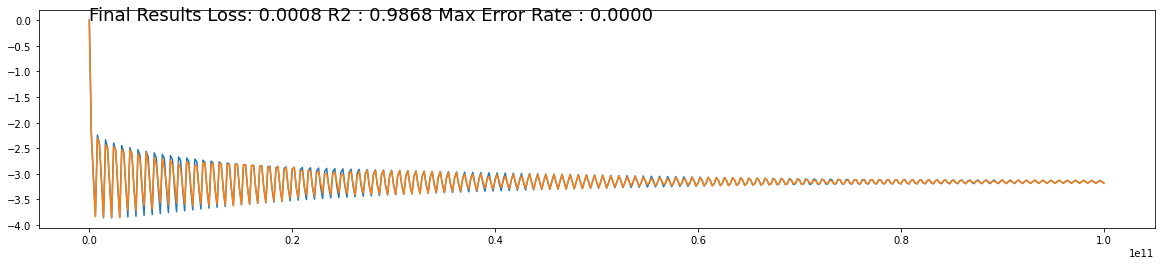

In [7]:
# Scan all the S parameters to generate test data
for i in 1, 2, 3, 4:
    for j in 1, 2, 3, 4:
        
        for k in 'A', 'P':
            
            # Train A(i, j) and P(i, j)
            output_col = '%s(%1d,%1d)' % (k,i,j)
            network = MLP(in_features, out_features, dropout_rate=0.0)
            models[output_col] = Model.Model(df, network, indices, input_cols, output_col, in_features, out_features, device, postfix='MLP')
            
            # Train the model
            if retrain == True:
                models[output_col].train(0.001, 40000)
                predictions[output_col] = models[output_col].test()
            else:
                models[output_col].load_model()
                
            # Test the model
            predictions[output_col] = models[output_col].test()
        
        predictions['SR(%1d,%1d)'%(i,j)] = predictions['A(%1d,%1d)'%(i,j)] * torch.cos(predictions['P(%1d,%1d)'%(i,j)])
        predictions['SI(%1d,%1d)'%(i,j)] = predictions['A(%1d,%1d)'%(i,j)] * torch.sin(predictions['P(%1d,%1d)'%(i,j)])
        
        for k in 'SR', 'SI':
            criterion = nn.MSELoss()
            y_test = torch.Tensor(df.loc[indices['test_idx']]['%s(%1d,%1d)'%(k,i,j)].to_numpy().reshape(-1, 501)).to(device)
            test_loss = criterion(predictions['%s(%1d,%1d)'%(k,i,j)], y_test)
            r2 = r2_score(predictions['%s(%1d,%1d)'%(k,i,j)].detach().cpu().numpy(), y_test.detach().cpu().numpy())
            mer = torch.nan_to_num(torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test))

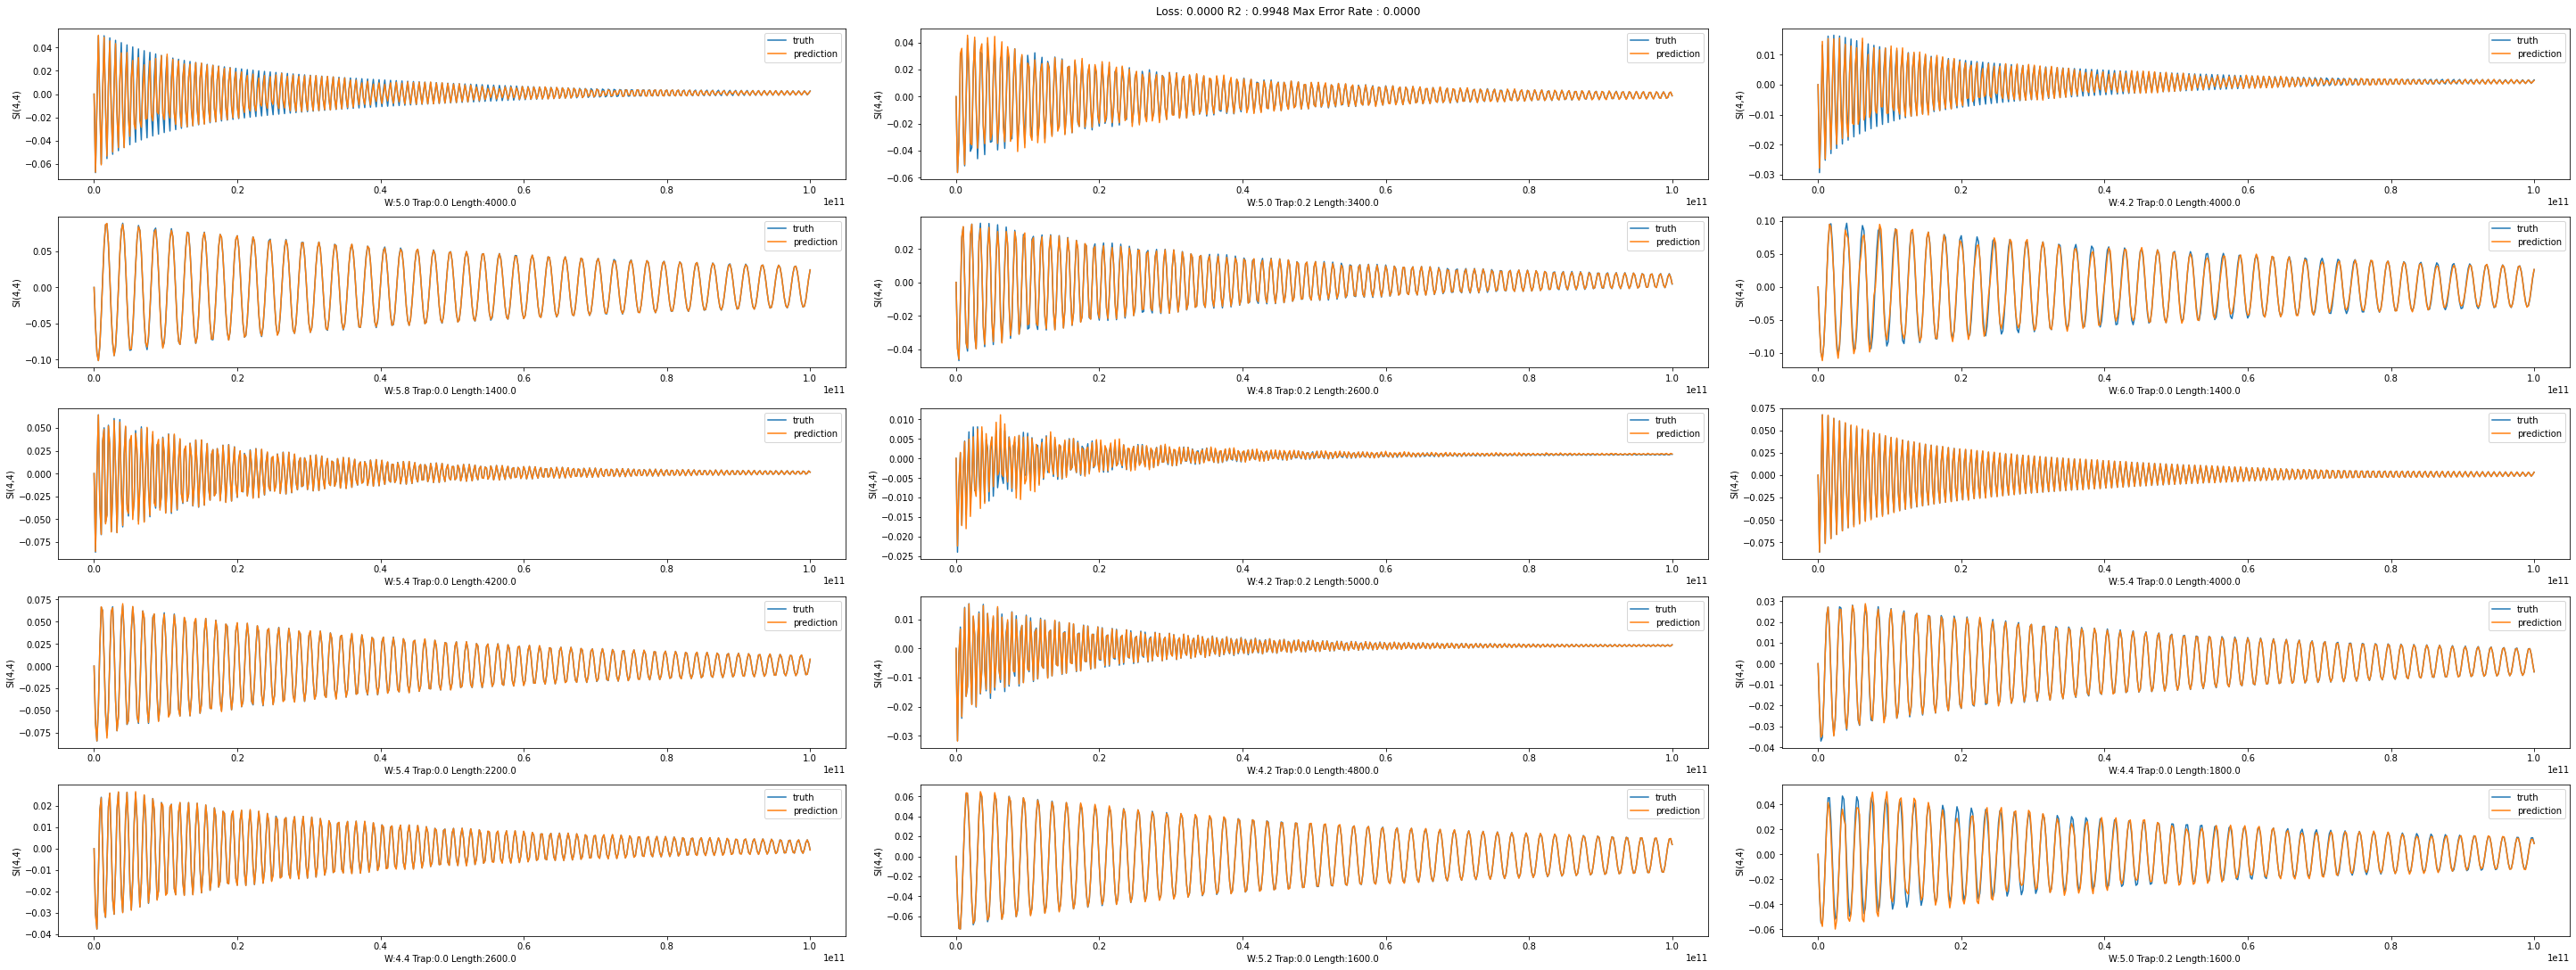

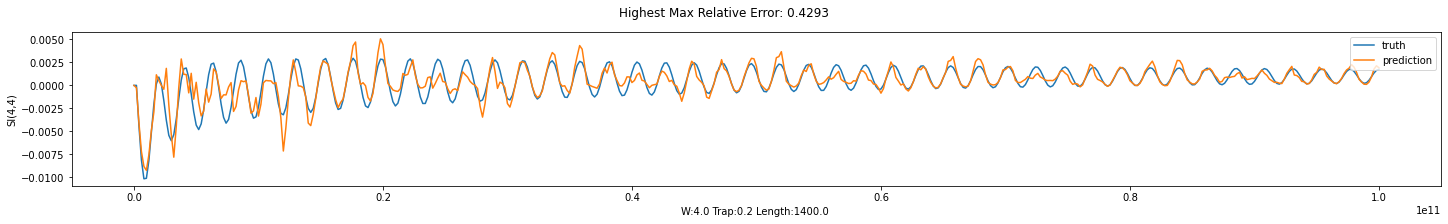

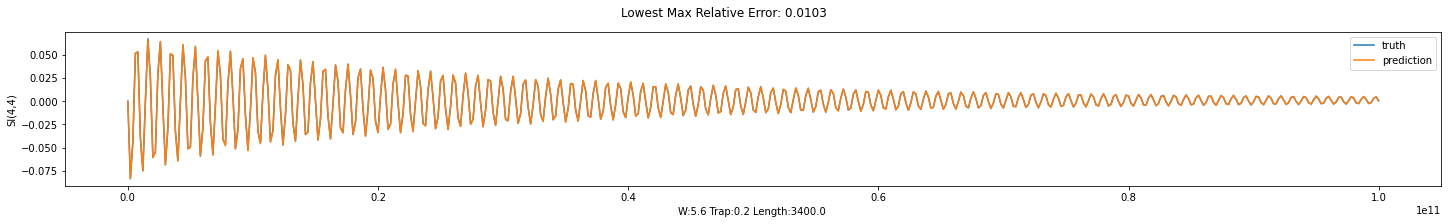

In [8]:
# Generate dataframe to store the error data
df_analysis = df.loc[indices['test_idx']].xs(0, level=1, drop_level=False).copy()

# Calculate the apperance of each parameter in the dataset
value_count = {}
for input_col in input_cols:
    value_count[input_col] = {}
    for idx in indices['train_idx']:
        value = df.loc[idx][input_col][0]
        if value in value_count[input_col]:
            value_count[input_col][value] += 1
        else:
            value_count[input_col][value] = 0
            
average_count = {}
average_count['W'] = len(indices['train_idx']) / 11.0
average_count['Trap'] = len(indices['train_idx']) / 2.0
average_count['Length'] = len(indices['train_idx']) / 21.0

for input_col in input_cols:
    df_analysis[input_col+'_appearance'] = np.zeros((len(indices['test_idx'] ), 1))
    for idx in df_analysis.index:
        df_analysis.loc[idx, input_col+'_appearance'] = value_count[input_col][df_analysis.loc[idx][input_col]] / average_count[input_col]

# Analyze error and plot
for i in 1, 2, 3, 4:
    for j in 1, 2, 3, 4:
        for k in 'SR', 'SI':
            output_col = '%s(%1d,%1d)'%(k,i,j)
            y_test = torch.Tensor(df.loc[indices['test_idx']]['%s(%1d,%1d)'%(k,i,j)].to_numpy().reshape(-1, 501)).to(device)
            y_test_max, y_test_max_idx = torch.max(y_test, dim=-1, keepdim=True)
            y_test_min, y_test_min_idx = torch.min(y_test, dim=-1, keepdim=True)
            y_test_range = y_test_max - y_test_min
            
            
            # Define error
            mean_absolute_error = torch.mean(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test), dim=-1)
            max_absolute_error, max_absolute_error_idx = torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test), dim=-1)
            
            mean_realtive_error = torch.mean(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test_range, dim=-1)
            max_realtive_error, max_realtive_error_idx = torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test_range, dim=-1)
            error_np = np.asarray([mean_absolute_error.cpu().numpy(), max_absolute_error.cpu().numpy(), mean_realtive_error.cpu().numpy(), max_realtive_error.cpu().numpy()])
            error_np = np.swapaxes(error_np,0,1)
            error_columns = [output_col+'_mean_absolute_error', output_col+'_max_absolute_error', output_col+'_mean_realtive_error', output_col+'_max_realtive_error']
            error_df = pd.DataFrame(error_np, index=df_analysis.index, columns=error_columns)
            df_analysis = pd.concat([df_analysis, error_df], axis=1)
            

            '''
            df_analysis[output_col+'_mean_absolute_error'] = mean_absolute_error.cpu().numpy()
            df_analysis[output_col+'_max_absolute_error'] = max_absolute_error.cpu().numpy()
            df_analysis[output_col+'_mean_realtive_error'] = mean_realtive_error.cpu().numpy()
            df_analysis[output_col+'_max_realtive_error'] = max_realtive_error.cpu().numpy()            
            '''
            # Calculate the relation between error and parameter appearance in training set
            appearnce = [x + '_appearance' for x in input_cols]
            A = df_analysis[appearnce].to_numpy()
            b = df_analysis[output_col+'_mean_realtive_error'].to_numpy()
            X, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
            rela_df = pd.DataFrame(np.ones((len(indices['test_idx'] ), len(input_cols))) * X, index=df_analysis.index, columns=[x + '_' + output_col + '_relation' for x in input_cols])
            df_analysis = pd.concat([df_analysis, rela_df], axis=1)
            
            # Get the index of the largest and smallest max relative error
            idx_h = np.where(df_analysis.index.get_loc(df_analysis.loc[:, output_col+'_max_realtive_error'].idxmax()[0]))[0][0]
            idx_l = np.where(df_analysis.index.get_loc(df_analysis.loc[:, output_col+'_max_realtive_error'].idxmin()[0]))[0][0]

            max_mer = df_analysis.loc[:, output_col+'_max_realtive_error'].max()
            min_mer = df_analysis.loc[:, output_col+'_max_realtive_error'].min()
            
            criterion = nn.MSELoss()
            test_loss = criterion(predictions['%s(%1d,%1d)'%(k,i,j)], y_test)
            r2 = r2_score(predictions['%s(%1d,%1d)'%(k,i,j)].detach().cpu().numpy(), y_test.detach().cpu().numpy())
            mer = torch.nan_to_num(torch.max(torch.abs(predictions['%s(%1d,%1d)'%(k,i,j)] - y_test) / y_test))
        
            plot_X_y_with_example(F.cpu(), y_test.cpu(), df, indices['test_idx'], input_cols, '%s(%1d,%1d)'%(k,i,j), predictions['%s(%1d,%1d)'%(k,i,j)].cpu(), \
                                  test_loss, r2, mer, idx_h, max_mer, idx_l, min_mer, figname='%s(%1d,%1d)'%(k,i,j), savefig=True)

In [9]:
df_analysis.to_csv('../Data/Out/test_data_analysis.csv')

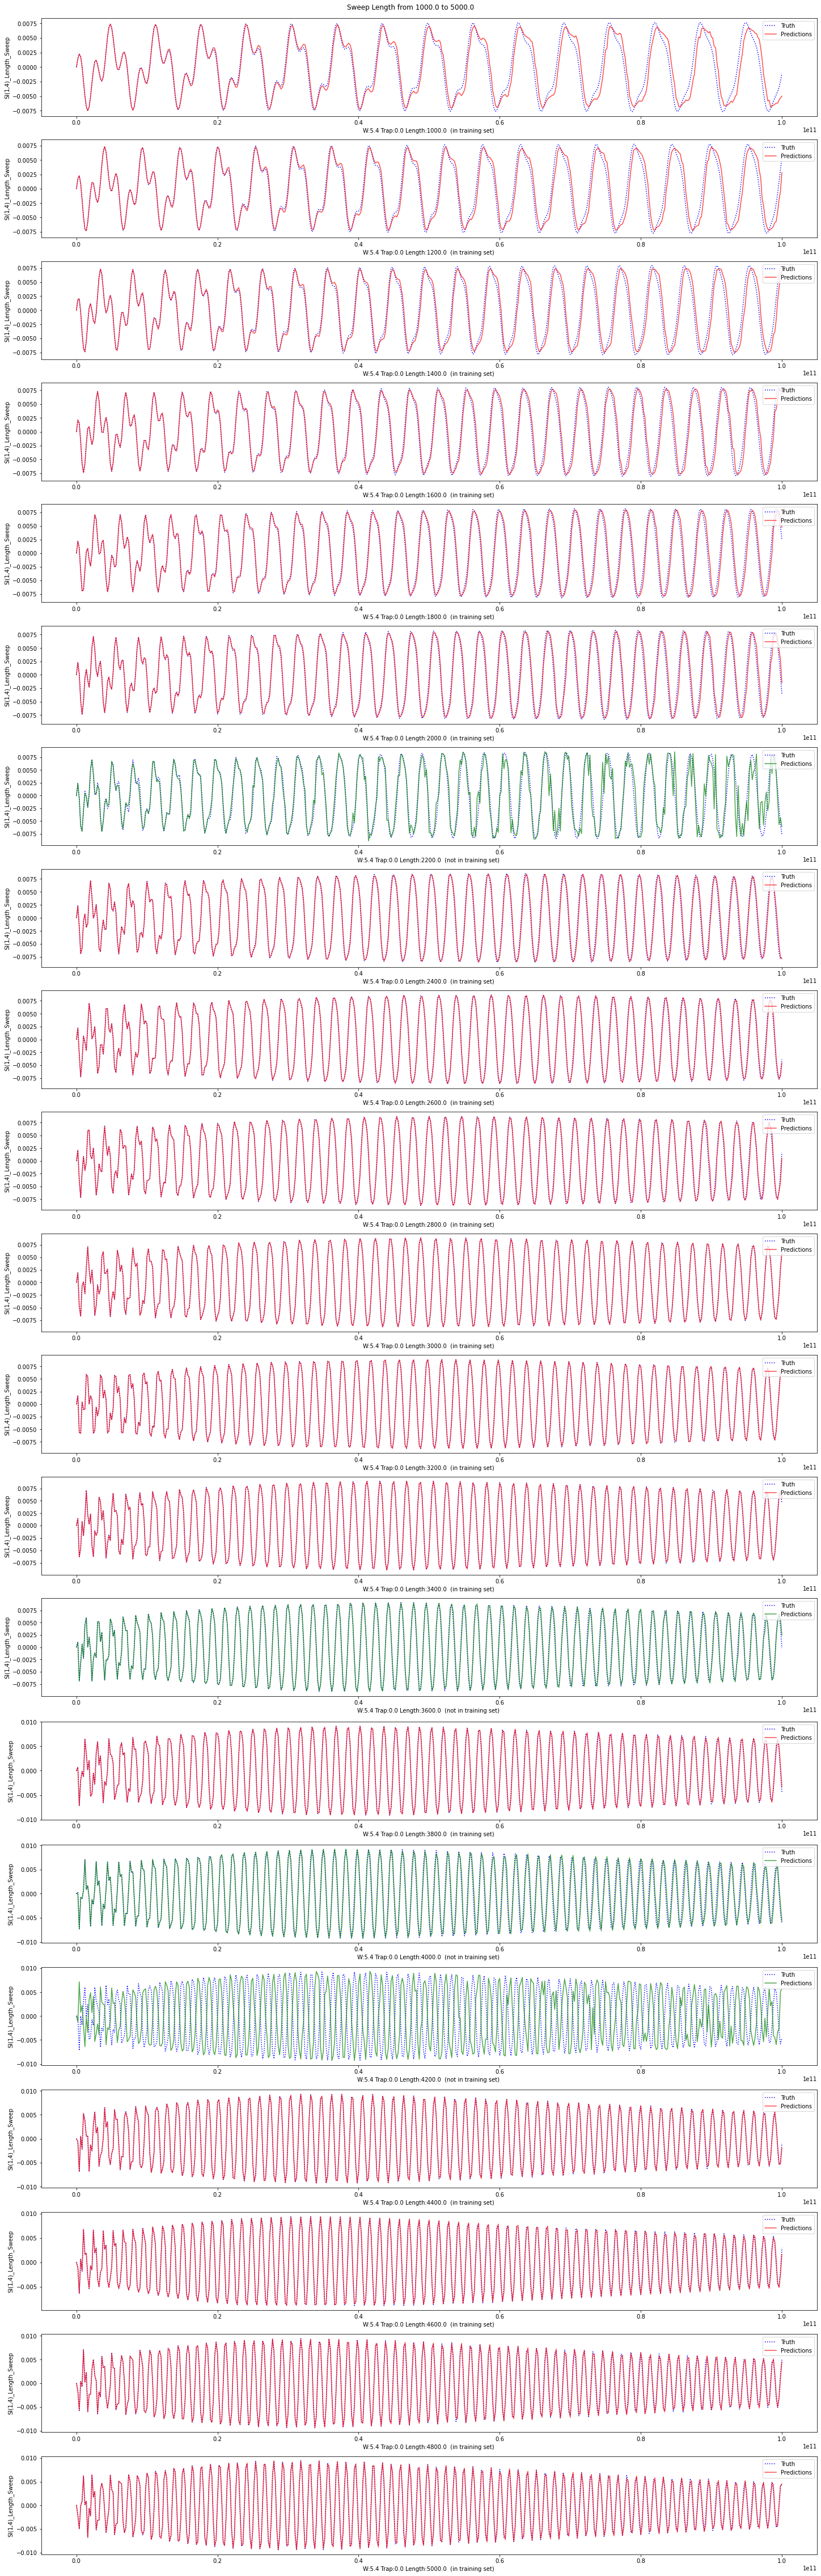

In [10]:
# Define the start stop step count
Sweep_parameters = {'W': (4, 6, 0.2, 11), \
                    'Trap': (0, 0.2, 0.2, 2), \
                    'Length': (1000, 5000, 200, 21)}

predictions_analysis = {}
truth_analysis = {}
indices_analysis = {}

# Sweep error and plot
for i in 1, :
    for j in 1, 2, 3, 4:
        for k in 'SR', 'SI':
            

            # Locate the worst max error case
            output_col = '%s(%1d,%1d)'%(k,i,j)
            idx_h = df_analysis.loc[:, output_col+'_max_realtive_error'].idxmax()
            
            # Get the corresponding input parameters
            input_cols_value = {}
            for input_col in input_cols:
                input_cols_value[input_col] = df.loc[idx_h][input_col]     
            
            # Sweep the parameters
            for input_col in input_cols:
                start, stop, step, count = Sweep_parameters[input_col]
                sweep_values = {}
                
                # Plot every possible combinations
                in_train = []
                indices_analysis[output_col+'_'+input_col+'_Sweep'] = []
                y = []
                X = []
                
                for c in range(count):
                    
                    # Set the sweeped parameter values
                    for input_col_inner in input_cols:
                        if input_col_inner == input_col:                            
                            sweep_values[input_col_inner] = start + step * c
                        else:
                            sweep_values[input_col_inner] = input_cols_value[input_col_inner]

                    # Get the truth value in the dataset
                    data = df.copy()
                    for input_col_inner in input_cols:
                        data = data.loc[:][(data[input_col_inner]) == sweep_values[input_col_inner]]
                    idx = data.index
                    if len(idx) == 0:
                        pass
                    else:
                        y.append(data[output_col].to_numpy())
                        X.append([sweep_values[input_col_inner] for input_col_inner in input_cols])
                        indices_analysis[output_col+'_'+input_col+'_Sweep'].append(idx[0][0])
                        if idx[0][0] in indices['train_idx']:
                            in_train.append(True)
                        else:
                            in_train.append(False)
                
                # Predict the data
                X = torch.Tensor(X).to(device)
                if k == 'SR':
                    predictions_analysis[output_col+'_'+input_col+'_Sweep'] = models['A(%1d,%1d)'%(i,j)].predict(X) * torch.cos(models['P(%1d,%1d)'%(i,j)].predict(X))
                else:
                    predictions_analysis[output_col+'_'+input_col+'_Sweep'] = models['A(%1d,%1d)'%(i,j)].predict(X) * torch.sin(models['P(%1d,%1d)'%(i,j)].predict(X))
                
                truth_analysis[output_col+'_'+input_col+'_Sweep'] = torch.Tensor(y).to(device)
                # Plot
                plot_X_y_analysis(F.cpu(), predictions_analysis[output_col+'_'+input_col+'_Sweep'].cpu(), indices_analysis[output_col+'_'+input_col+'_Sweep'], in_train, \
                                  input_cols, output_col+'_'+input_col+'_Sweep', y=truth_analysis[output_col+'_'+input_col+'_Sweep'].cpu(),  \
                                  title="Sweep %s from %.1f to %.1f" % (input_col, start, stop), figname=output_col+'_'+input_col+'_Sweep', savefig=True)

# Previous Code

In [ ]:
# Sweep W
predictions_analysis = {}
truth_analysis = {}
indices_analysis = {}
# Plot every possible combinations
in_train = []
indices_analysis['A(1,1)'] = []
y = []
X = []
for W_i in range(11):
    W = float(4.0 + 0.2 * W_i)
    Trap = 0.0
    Lenth = 3200
    data = df.loc[:][(df['W'] == W) & (df['Trap'] == 0.0 )& (df['Length'] == 3200)]
    idx = data.index
    if len(idx) == 0:
        pass
    else:
        y.append(data['A(1,1)'].to_numpy())
        X.append([W, 0.0, 3200])
        indices_analysis['A(1,1)'].append(idx[0][0])
        if idx[0][0] in indices['train_idx']:
            in_train.append(True)
        else:
            in_train.append(False)
X = torch.Tensor(X).to(device)
predictions_analysis['A(1,1)'] = models['A(1,1)'].predict(X)
truth_analysis['A(1,1)'] = torch.Tensor(y).to(device)
# Plot
plot_X_y_analysis(F.cpu(), predictions_analysis['A(1,1)'].cpu(), indices_analysis['A(1,1)'], in_train, input_cols, 'A(1,1)', y=truth_analysis['A(1,1)'].cpu(),  \
                  title="Sweep W from 4.0 to 6.0", figname='Sweep_W', savefig=True)

In [ ]:
# Sweep Trap
predictions_analysis = {}
truth_analysis = {}
indices_analysis = {}
# Plot every possible combinations
in_train = []
indices_analysis['A(1,1)'] = []
y = []
X = []
for Trap_i in range(2):
    W = 4.4
    Trap = 0.0 + 0.2 * Trap_i
    Length = 3200
    data = df.loc[:][(df['W'] == W) & (df['Trap'] == Trap)& (df['Length'] == Length)]
    idx = data.index
    if len(idx) == 0:
        pass
    else:
        y.append(data['A(1,1)'].to_numpy())
        X.append([W, Trap, Length])
        indices_analysis['A(1,1)'].append(idx[0][0])
        if idx[0][0] in indices['train_idx']:
            in_train.append(True)
        else:
            in_train.append(False)
X = torch.Tensor(X).to(device)
predictions_analysis['A(1,1)'] = models['A(1,1)'].predict(X)
truth_analysis['A(1,1)'] = torch.Tensor(y).to(device)
# Plot
plot_X_y_analysis(F.cpu(), predictions_analysis['A(1,1)'].cpu(), indices_analysis['A(1,1)'], in_train, input_cols, 'A(1,1)', y=truth_analysis['A(1,1)'].cpu(),  \
                  title="Sweep Trap from 0.0 to 0.2", figname='Sweep_Trap', savefig=True)

In [ ]:
# Sweep Length
predictions_analysis = {}
truth_analysis = {}
indices_analysis = {}
# Plot every possible combinations
in_train = []
indices_analysis['A(1,1)'] = []
y = []
X = []
for Length_i in range(21):
    W = 4.4
    Trap = 0.0
    Length = 1000 + 200 * Length_i
    data = df.loc[:][(df['W'] == W) & (df['Trap'] == Trap)& (df['Length'] == Length)]
    idx = data.index
    if len(idx) == 0:
        pass
    else:
        y.append(data['A(1,1)'].to_numpy())
        X.append([W, Trap, Length])
        indices_analysis['A(1,1)'].append(idx[0][0])
        if idx[0][0] in indices['train_idx']:
            in_train.append(True)
        else:
            in_train.append(False)
X = torch.Tensor(X).to(device)
predictions_analysis['A(1,1)'] = models['A(1,1)'].predict(X)
truth_analysis['A(1,1)'] = torch.Tensor(y).to(device)
# Plot
plot_X_y_analysis(F.cpu(), predictions_analysis['A(1,1)'].cpu(), indices_analysis['A(1,1)'], in_train, input_cols, 'A(1,1)', y=truth_analysis['A(1,1)'].cpu(),  \
                  title="Sweep Length from 1000 to 5000", figname='Sweep_Length', savefig=True)

In [ ]:
df_analysis['mean_absolute_error'] = mean_absolute_error.cpu().numpy()
df_analysis['max_absolute_error'] = max_absolute_error.cpu().numpy()
df_analysis['mean_realtive_error'] = mean_realtive_error.cpu().numpy()
df_analysis['max_realtive_error'] = max_realtive_error.cpu().numpy()
for input_col in input_cols:
    df_analysis[input_col+'_appearance'] = np.zeros((len(indices['test_idx'] ), 1))
    for idx in df_analysis.index:
        df_analysis.loc[idx, input_col+'_appearance'] = value_count[input_col][df_analysis.loc[idx][input_col]] / average_count[input_col]

In [ ]:
df_analysis

In [ ]:
idx_h = np.where(df_analysis.index.get_loc(df_analysis.loc[:, 'max_realtive_error'].idxmax()[0]))[0][0]
idx_l = np.where(df_analysis.index.get_loc(df_analysis.loc[:, 'max_realtive_error'].idxmin()[0]))[0][0]

mre_h = df_analysis.loc[:, 'max_realtive_error'].max()
mre_l = df_analysis.loc[:, 'max_realtive_error'].min()

In [ ]:
mre_h

In [ ]:
# Test the correaltion between appearance and error
appearnce = [x + '_appearance' for x in input_cols]
A = df_analysis[appearnce].to_numpy()

In [ ]:
b = df_analysis['mean_absolute_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
b = df_analysis['max_absolute_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
b = df_analysis['mean_realtive_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
b = df_analysis['max_realtive_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
# Test the correaltion between parameters and error
A = models['A(1,1)'].X_test_norm.cpu().numpy()

In [ ]:
b = df_analysis['mean_absolute_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
b = df_analysis['max_absolute_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
b = df_analysis['mean_realtive_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
b = df_analysis['max_realtive_error'].to_numpy()
np.linalg.lstsq(A, b, rcond=None)

In [ ]:
df_train_WL = df.loc[indices['train_idx']][input_cols].xs(0, level=1, drop_level=False) * [5, 5, 1/200]

In [ ]:
df_analysis['mean_distance'] = np.zeros((len(indices['test_idx'] ), 1))
df_analysis['neighbour_num'] = np.zeros((len(indices['test_idx'] ), 1))

for i in df_analysis.index:
    min_distance = 10000
    min_distance_idx = None
    d = (df_analysis.loc[i][input_cols] * [5, 5, 1/200] - df_train_WL[input_cols]).pow(2).sum(axis=1)
    df_analysis.loc[i, 'mean_distance'] = d.mean()
    df_analysis.loc[i, 'neighbour_num'] = (d == 1.0).sum()

In [ ]:
df_analysis

In [ ]:
_ = plt.plot(df_analysis['neighbour_num'], df_analysis['max_realtive_error'], 'o', label='Original data', markersize=10)
                                             